#### Import libraries

In [1]:
from keras.models import *
from keras.layers import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from skimage.io import imshow
from scipy.io import loadmat
import tensorflow as tf
import keras

Using TensorFlow backend.


#### FCN32 model
-Five max-pooling to reduce the size of image by 1/32

In [2]:
# Classes
classes = 21
# Image size
height, width = (224, 224)
# Image input - Tensorflow format
imgInput = Input(batch_shape=(None, height, width, 3))
# Image format - Tensorflow dataflow convention
IMAGE_ORDERING = 'channels_last'
# Convolution block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', data_format=IMAGE_ORDERING )(imgInput)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
f1 = x
# Convolution block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', data_format=IMAGE_ORDERING )(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
f2 = x
# Convolution block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', data_format=IMAGE_ORDERING )(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', data_format=IMAGE_ORDERING )(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
f3 = x
# Convolution block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', data_format=IMAGE_ORDERING )(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', data_format=IMAGE_ORDERING )(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)
f4 = x
# Convolution block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', data_format=IMAGE_ORDERING )(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', data_format=IMAGE_ORDERING )(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
f5 = x
# Not used in FCN but used to add weights for first half of the model
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(1000 , activation='softmax', name='predictions')(x)
# Load object classification weights to learn quickly
vgg16 = Model(imgInput, x)
vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5')
# Convolutionalized fully connected layers
o = f5
o = (Conv2D(4096 , (7, 7), activation='relu', padding='same', data_format=IMAGE_ORDERING, name='fc6'))(o)
o = Dropout(0.5)(o)
o = (Conv2D(4096 , (1, 1), activation='relu', padding='same', data_format=IMAGE_ORDERING, name='fc7'))(o)
o = Dropout(0.5)(o)
# Transform all the features to the individual classes
o = (Conv2D(classes, (1, 1), activation='linear', kernel_initializer='he_normal', padding='valid', strides=(1, 1), data_format=IMAGE_ORDERING, name='score_fr'))(o)
# Deconvolve back to orignal image size
o = Conv2DTranspose(21, kernel_size=(64,64),strides=(32,32), data_format=IMAGE_ORDERING, name='upsample')(o)
# o = Deconvolution2D(21, kernel_size=(64, 64), strides=(32, 32), padding='valid', activation=None, name='upsample')(o)
o = Cropping2D(cropping=16)(o)
# Activation
o = (Activation('softmax'))(o)
# Model summary
FCN32 = Model(imgInput, o)
FCN32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
def mean_categorical_crossentropy(y_true, y_pred):
    if K.image_data_format() == 'channels_last':
        loss = K.mean(keras.losses.categorical_crossentropy(y_true, y_pred), axis=[1, 2])
    elif K.image_data_format() == 'channels_first':
        loss = K.mean(keras.losses.categorical_crossentropy(y_true, y_pred), axis=[2, 3])
    print(loss)
    return loss

In [4]:
FCN32.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# FCN32.compile(loss=mean_categorical_crossentropy, optimizer='adagrad', metrics=['accuracy'])

#### Data preprocessing

In [5]:
# Directory needed
val_image_dir = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/JPEGImages/'
val_target_dir = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/SegmentationClass/'
trainText = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/ImageSets/Segmentation/train.txt'
validText = '/Users/Andrew/Documents/School/CS_6831/Project/VOC2011/ImageSets/Segmentation/trainval.txt'

# Getting training names in the train.txt
filenames_f = open(trainText, "r")
filenames = []
for line in filenames_f:
    line = line.strip()
    filenames.append(line)
filenames_f.close()   
print('~~Training dataset~~')
# Display number of training names
print('Number of training names:', len(filenames))
# Grab training dataset
images = []
for i in range(len(filenames)):
    images.append(val_image_dir + filenames[i] + '.jpg')
images.sort()
print('Number of test images:', len(images))
# Grab ground truth dataset
segmentations = []
for i in range(len(filenames)):
    segmentations.append(val_target_dir + filenames[i] + '.png')
segmentations.sort()
print('Number of ground truth images:', len(segmentations))
# Getting validation names in the trainval.txt
print('~~Validation dataset~~')
filenames_f = open(validText, "r")
filenamesV = []
for line in filenames_f:
    line = line.strip()
    filenamesV.append(line)
filenames_f.close()
print('Number of validation names:', len(filenamesV))
# Grab validation dataset
vimages = []
for i in range(len(filenamesV)):
    vimages.append(val_image_dir + filenamesV[i] + '.jpg')
vimages.sort()
print('Number of ground truth images for Validation:', len(vimages))

~~Training dataset~~
Number of training names: 1112
Number of test images: 1112
Number of ground truth images: 1112
~~Validation dataset~~
Number of validation names: 2223
Number of ground truth images for Validation: 2223


In [6]:
def binarylab(labels, size, nb_class):
    y = np.zeros((size,size, nb_class))
    for i in range(size):
        for j in range(size):
            y[i, j, labels[i][j]] = 1
    return y

def load_data(path, size, label=None):
    img = Image.open(path)
    w, h = img.size
    if w < h:
        if w < size:
            img = img.resize((size, size* h // w))
            w, h = img.size
    else:
        if h < size:
            img = img.resize((size * w // h, size))
            w, h = img.size
    
    img = img.resize((size, size))
    
    if label:
        y = np.array(img, dtype=np.int32)
        mask = y == 255
        y[mask] = 0
        y = binarylab(y, size, 21)
        y = np.expand_dims(y, axis=0)
        return y
    else:
        X = image.img_to_array(img)
        X = np.expand_dims(X, axis=0)
        X = preprocess_input(X)
        return X

def generate_arrays_from_file(names, path_to_train, path_to_target, img_size, nb_class):
    while True:
        for name in names:
            Xpath = path_to_train + "{}.jpg".format(name)
            ypath = path_to_target + "{}.png".format(name)
            X = load_data(Xpath, img_size, label=False)
            y = load_data(ypath, img_size, label=True)
            yield np.array(X) , np.array(y)

#### Test generator function

In [7]:
X = generate_arrays_from_file(filenames, val_image_dir, val_target_dir, width, classes)
X_get = next(X)
print('Input Shape:', X_get[0].shape)
print('Validation Shape:', X_get[1].shape)

Input Shape: (1, 224, 224, 3)
Validation Shape: (1, 224, 224, 21)


#### Training

In [8]:
# # Variables
# classes = 21
# epochs = 100
# nb_data = len(filenames)
# nbv_data = len(filenamesV)

# # FCN32.fit_generator(generator=generate_arrays_from_file(filenames, val_image_dir, val_target_dir, width, classes),
# #                     steps_per_epoch=nb_data,
# # #                     validation_data=generate_arrays_from_file(filenamesV, val_image_dir, val_target_dir, width, classes),
# # #                     validation_steps=nbv_data,
# #                     epochs=epochs)


# X = load_data('/Users/Andrew/Documents/School/CS_6831/Project/VOC2012/JPEGImages/2007_000032.jpg', 224, label=False)
# y = load_data('/Users/Andrew/Documents/School/CS_6831/Project/VOC2012/SegmentationClass/2007_000032.png', 224, label=True)
# print(X.shape)
# print(y.shape)
# FCN32.fit(X, y, epochs=200)

In [9]:
# FCN32.save('epoch50.h5')

In [10]:
# FCN32 = load_model('epoch50.h5')

In [11]:
data = loadmat('pascal-fcn32s-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description


def copy_mat_to_keras(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]
    for i in range(0, p.shape[1]-1, 2):
        matname = '_'.join(p[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print ('found : ', (str(matname), kindex))
            l_weights = p[0,i].value
            l_bias = p[0,i+1].value
            kmodel.layers[kindex].set_weights([l_weights, l_bias[:,0]])
        else:
            print ('not found: ', str(matname)
)
            
copy_mat_to_keras(FCN32)

found :  ('conv1_1', 1)
found :  ('conv1_2', 2)
found :  ('conv2_1', 4)
found :  ('conv2_2', 5)
found :  ('conv3_1', 7)
found :  ('conv3_2', 8)
found :  ('conv3_3', 9)
found :  ('conv4_1', 11)
found :  ('conv4_2', 12)
found :  ('conv4_3', 13)
found :  ('conv5_1', 15)
found :  ('conv5_2', 16)
found :  ('conv5_3', 17)
found :  ('fc6', 19)
found :  ('fc7', 21)
found :  ('score_fr', 23)
found :  ('upsample', 24)


#### Prediction

In [12]:
def prepareim(im):
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = np.expand_dims(im, axis=0)
    return im

In [13]:
# subset = filenames[0: len(filenames)]
# S = np.random.choice(len(filenames))
# # S = 0

# # Imput Image
# inputImg = cv2.imread(images[S])
# inputImg = cv2.resize(inputImg, (224, 224)) 
# # Ground Truth Image
# segImg = cv2.imread(segmentations[S])
# segImg = cv2.resize(segImg, (224, 224)) 
# # Prediction Image
# inputImgP = inputImg.astype('float64')
# inputImgP = prepareim(inputImgP)
# preds = FCN32.predict(inputImgP)
# print(preds.shape)
# imclass = np.argmax(preds, axis=3)[0,:,:]
# # print(np.ma.masked_where(preds == 0.0, preds))
# # Show Image
# plt.figure()
# plt.subplot(1,3,1)
# plt.imshow(inputImg)
# plt.subplot(1,3,2)
# plt.imshow(segImg)
# plt.subplot(1,3,3)
# # plt.imshow(imclass)
# # masked_imclass = np.ma.masked_where(imclass == 0, imclass)
# plt.imshow( imclass, alpha=0.5 )
# # plt.imshow(masked_imclass, alpha=0.5)
# plt.show()


(224, 224)


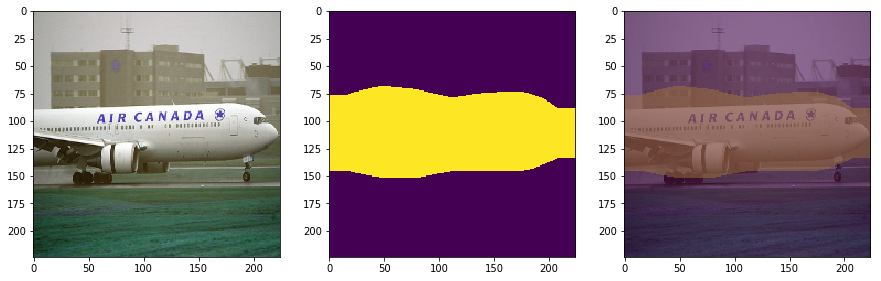

In [41]:
subset = filenames[0: len(filenames)]
S = np.random.choice(len(filenames))
S = 25

# Imput Image
inputImg = cv2.imread(images[S])
inputImg = cv2.resize(inputImg, (224, 224))

inputImgP = inputImg.astype('float64')
inputImgP = prepareim(inputImgP)
preds = FCN32.predict(inputImgP)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(imclass.shape)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(inputImg) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(inputImg) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

plt.show()